Primer CSV

In [1]:
import requests
import pandas as pd
import numpy as np
import datetime

# Setting this option will print all columns of a dataframe
pd.set_option('display.max_columns', None)
# Setting this option will print all of the data in a feature
pd.set_option('display.max_colwidth', None)

# Helper functions
def getBoosterVersion(data):
    for x in data['rocket']:
        if x:
            response = requests.get("https://api.spacexdata.com/v4/rockets/" + str(x)).json()
            BoosterVersion.append(response['name'])

def getLaunchSite(data):
    for x in data['launchpad']:
        if x:
            response = requests.get("https://api.spacexdata.com/v4/launchpads/" + str(x)).json()
            Longitude.append(response['longitude'])
            Latitude.append(response['latitude'])
            LaunchSite.append(response['name'])

def getPayloadData(data):
    for load in data['payloads']:
        if load:
            response = requests.get("https://api.spacexdata.com/v4/payloads/" + load).json()
            PayloadMass.append(response['mass_kg'])
            Orbit.append(response['orbit'])

def getCoreData(data):
    for core in data['cores']:
        if core['core'] != None:
            response = requests.get("https://api.spacexdata.com/v4/cores/" + core['core']).json()
            Block.append(response['block'])
            ReusedCount.append(response['reuse_count'])
            Serial.append(response['serial'])
        else:
            Block.append(None)
            ReusedCount.append(None)
            Serial.append(None)
        Outcome.append(str(core['landing_success']) + ' ' + str(core['landing_type']))
        Flights.append(core['flight'])
        GridFins.append(core['gridfins'])
        Reused.append(core['reused'])
        Legs.append(core['legs'])
        LandingPad.append(core['landpad'])

# Request to the SpaceX API
spacex_url = "https://api.spacexdata.com/v4/launches/past"
response = requests.get(spacex_url)
data = response.json()

# Use json_normalize method to convert the json result into a dataframe
data = pd.json_normalize(data)

# Subset the dataframe
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# Remove rows with multiple cores and multiple payloads
data = data[data['cores'].map(len) == 1]
data = data[data['payloads'].map(len) == 1]

# Extract the single value in the list
data['cores'] = data['cores'].map(lambda x: x[0])
data['payloads'] = data['payloads'].map(lambda x: x[0])

# Convert the date_utc to a datetime datatype and extract the date
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# Restrict the dates of the launches
data = data[data['date'] <= datetime.date(2020, 11, 13)]

# Global variables
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

# Apply helper functions
getBoosterVersion(data)
getLaunchSite(data)
getPayloadData(data)
getCoreData(data)

# Construct the dataset
launch_dict = {
    'FlightNumber': list(data['flight_number']),
    'Date': list(data['date']),
    'BoosterVersion': BoosterVersion,
    'PayloadMass': PayloadMass,
    'Orbit': Orbit,
    'LaunchSite': LaunchSite,
    'Outcome': Outcome,
    'Flights': Flights,
    'GridFins': GridFins,
    'Reused': Reused,
    'Legs': Legs,
    'LandingPad': LandingPad,
    'Block': Block,
    'ReusedCount': ReusedCount,
    'Serial': Serial,
    'Longitude': Longitude,
    'Latitude': Latitude
}

# Create a DataFrame
data_falcon9 = pd.DataFrame(launch_dict)

# Filter to only include Falcon 9 launches
data_falcon9 = data_falcon9[data_falcon9['BoosterVersion'] != 'Falcon 1']

# Reset the FlightNumber column
data_falcon9.loc[:, 'FlightNumber'] = list(range(1, data_falcon9.shape[0] + 1))

# Dealing with Missing Values
data_falcon9['PayloadMass'].fillna(data_falcon9['PayloadMass'].mean(), inplace=True)

# Export to CSV
data_falcon9.to_csv('dataset_part_1.csv', index=False)

print("CSV file 'dataset_part_1.csv' has been created successfully.")


CSV file 'dataset_part_1.csv' has been created successfully.


BASE CON WEBSP

In [15]:
import requests
from bs4 import BeautifulSoup
import re
import unicodedata
import pandas as pd

# Helper functions
def date_time(table_cells):
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    out=''.join([booster_version for i, booster_version in enumerate(table_cells.strings) if i % 2 == 0][0:-1])
    return out

def landing_status(table_cells):
    out = [i for i in table_cells.strings][0]
    return out

def get_mass(table_cells):
    mass = unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass = mass[0:mass.find("kg")+2]
    else:
        new_mass = 0
    return new_mass

def extract_column_from_header(row):
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()
        
    colunm_name = ' '.join(row.contents)
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name    

# Request to the Wikipedia page
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"
response = requests.get(static_url)
soup = BeautifulSoup(response.text, 'html.parser')

# Extract tables
html_tables = soup.find_all('table', "wikitable plainrowheaders collapsible")

# Target table
first_launch_table = html_tables[2]

# Extract column names
column_names = []
for th in first_launch_table.find_all('th'):
    name = extract_column_from_header(th)
    if name is not None and len(name) > 0:
        column_names.append(name)

# Initialize the dictionary with column names
launch_dict = dict.fromkeys(column_names)
launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []
launch_dict['Version Booster'] = []
launch_dict['Booster landing'] = []
launch_dict['Date'] = []
launch_dict['Time'] = []

# Extract rows from the table and populate the dictionary
extracted_row = 0
for table_number, table in enumerate(soup.find_all('table', "wikitable plainrowheaders collapsible")):
    for rows in table.find_all("tr"):
        if rows.th:
            if rows.th.string:
                flight_number = rows.th.string.strip()
                flag = flight_number.isdigit()
        else:
            flag = False

        if flag:
            extracted_row += 1
            row = rows.find_all('td')
            flight_number = rows.th.string.strip()
            launch_dict['Flight No.'].append(flight_number)

            datatimelist = date_time(row[0])
            date = datatimelist[0].strip(',')
            launch_dict['Date'].append(date)
            time = datatimelist[1]
            launch_dict['Time'].append(time)

            bv = booster_version(row[1])
            if not(bv):
                bv = row[1].a.string
            launch_dict['Version Booster'].append(bv)

            launch_site = row[2].a.string
            launch_dict['Launch site'].append(launch_site)

            payload = row[3].a.string
            launch_dict['Payload'].append(payload)

            payload_mass = get_mass(row[4])
            launch_dict['Payload mass'].append(payload_mass)

            orbit = row[5].a.string
            launch_dict['Orbit'].append(orbit)

            customer = row[6].get_text(separator=" ", strip=True)
            launch_dict['Customer'].append(customer)

            launch_outcome = list(row[7].strings)[0]
            launch_dict['Launch outcome'].append(launch_outcome)

            booster_landing = landing_status(row[8])
            launch_dict['Booster landing'].append(booster_landing)

# Create a DataFrame
df = pd.DataFrame({key: pd.Series(value) for key, value in launch_dict.items()})

# Export to CSV
df.to_csv('spacex_web_scraped.csv', index=False)

print("CSV file 'spacex_web_scraped.csv' has been created successfully.")


CSV file 'spacex_web_scraped.csv' has been created successfully.


/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:123: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [5]:
print(df.head())


  Flight No.  Date and time ( ) Launch site  \
0          1                NaN       CCAFS   
1          2                NaN       CCAFS   
2          3                NaN       CCAFS   
3          4                NaN       CCAFS   
4          5                NaN       CCAFS   

                                Payload Payload mass Orbit Customer  \
0  Dragon Spacecraft Qualification Unit            0   LEO   SpaceX   
1                                Dragon            0   LEO     NASA   
2                                Dragon       525 kg   LEO     NASA   
3                          SpaceX CRS-1     4,700 kg   LEO     NASA   
4                          SpaceX CRS-2     4,877 kg   LEO     NASA   

  Launch outcome Version Booster Booster landing             Date   Time  
0      Success\n  F9 v1.0B0003.1         Failure      4 June 2010  18:45  
1        Success  F9 v1.0B0004.1         Failure  8 December 2010  15:43  
2        Success  F9 v1.0B0005.1    No attempt\n      22 May 2012

In [6]:
# Instalar las bibliotecas necesarias
!pip install sqlalchemy==1.3.9
!pip install ipython-sql
!pip install pandas==1.1.5


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 72.9 MB/s eta 0:00:00:00:010:01
  Preparing metadata (setup.py) ... done
  Created wheel for sqlalchemy: filename=SQLAlchemy-1.3.9-cp37-cp37m-linux_x86_64.whl size=1159121 sha256=d8422a5c050ce5d43766022ea3a021197926cbcd4424133691c0824af6cde108
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/03/71/13/010faf12246f72dc76b4150e6e599d13a85b4435e06fb9e51f
Successfully built sqlalchemy
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 1.3.24
    Uninstalling SQLAlchemy-1.3.24:
      Successfully uninstalled SQLAlchemy-1.3.24
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 91.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/pandas/core/generic.py:2882: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  both result in 0.1234 being formatted as 0.12.


 * sqlite:///my_data1.db
Done.


[]

In [16]:
# Cargar la extensión SQL
%load_ext sql

# Conectar a la base de datos SQLite
import csv, sqlite3

con = sqlite3.connect("my_data1.db")
cur = con.cursor()
%sql sqlite:///my_data1.db

import pandas as pd

# Cargar el dataset de SpaceX
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_2/data/Spacex.csv")
df.to_sql("SPACEXTBL", con, if_exists='replace', index=False, method="multi")

# Crear una tabla sin filas en blanco
%sql CREATE TABLE SPACEXTABLE AS SELECT * FROM SPACEXTBL WHERE Date IS NOT NULL;


The sql extension is already loaded. To reload it, use:
  %reload_ext sql
 * sqlite:///my_data1.db
(sqlite3.OperationalError) table SPACEXTABLE already exists
[SQL: CREATE TABLE SPACEXTABLE AS SELECT * FROM SPACEXTBL WHERE Date IS NOT NULL;]
(Background on this error at: http://sqlalche.me/e/e3q8)


In [17]:

# Cargar la extensión SQL
%reload_ext sql

# Conectar a la base de datos SQLite
import csv, sqlite3

con = sqlite3.connect("my_data1.db")
cur = con.cursor()
%sql sqlite:///my_data1.db

import pandas as pd

# Cargar el dataset de SpaceX desde el archivo CSV creado previamente
df = pd.read_csv("spacex_web_scraped.csv")
df.to_sql("SPACEXTBL", con, if_exists='replace', index=False, method="multi")

# Eliminar la tabla existente si existe
%sql DROP TABLE IF EXISTS SPACEXTABLE;

# Crear una tabla sin filas en blanco
%sql CREATE TABLE SPACEXTABLE AS SELECT * FROM SPACEXTBL WHERE Date IS NOT NULL;


 * sqlite:///my_data1.db
Done.
 * sqlite:///my_data1.db
Done.


[]

In [18]:
%sql SELECT DISTINCT "Launch site" FROM SPACEXTABLE;


 * sqlite:///my_data1.db
Done.


Launch site
CCAFS
VAFB
Cape Canaveral
KSC
CCSFS


In [19]:
%sql SELECT * FROM SPACEXTABLE WHERE "Launch site" LIKE 'CCA%' LIMIT 5;


 * sqlite:///my_data1.db
Done.


Flight No.,Date and time ( ),Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time
1,None,CCAFS,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,F9 v1.0B0003.1,Failure,4 June 2010,18:45
2,None,CCAFS,Dragon,0,LEO,NASA ( COTS ) NRO,Success,F9 v1.0B0004.1,Failure,8 December 2010,15:43
3,None,CCAFS,Dragon,525 kg,LEO,NASA ( COTS ),Success,F9 v1.0B0005.1,No attempt,22 May 2012,07:44
4,None,CCAFS,SpaceX CRS-1,"4,700 kg",LEO,NASA ( CRS ),Success,F9 v1.0B0006.1,No attempt,8 October 2012,00:35
5,None,CCAFS,SpaceX CRS-2,"4,877 kg",LEO,NASA ( CRS ),Success,F9 v1.0B0007.1,No attempt,1 March 2013,15:10


In [23]:
%sql SELECT SUM("Payload mass") FROM SPACEXTABLE WHERE "Customer" LIKE '%NASA%';


 * sqlite:///my_data1.db
Done.


"SUM(""Payload mass"")"
2101.0


In [24]:
%sql SELECT AVG("Payload mass") FROM SPACEXTABLE WHERE "Version Booster" = 'F9 v1.1';


 * sqlite:///my_data1.db
Done.


"AVG(""Payload mass"")"
82.42857142857143


In [42]:
%sql SELECT MIN(Date) FROM SPACEXTABLE WHERE "Booster landing" = 'Success';


 * sqlite:///my_data1.db
Done.


MIN(Date)
1 May 2017


In [39]:
# Cargar la extensión SQL
%reload_ext sql

# Conectar a la base de datos SQLite
import csv, sqlite3

con = sqlite3.connect("my_data1.db")
cur = con.cursor()
%sql sqlite:///my_data1.db

import pandas as pd

# Cargar el dataset de SpaceX desde el archivo CSV creado previamente
df = pd.read_csv("spacex_web_scraped.csv")

# Función para limpiar y convertir la columna Payload mass a float
def parse_payload_mass(mass):
    try:
        return float(str(mass).replace(' kg', '').replace(',', ''))
    except ValueError:
        return 0  # O puedes elegir otro valor predeterminado

# Aplicar la función para crear la columna PAYLOAD_MASS_KG
df['PAYLOAD_MASS_KG'] = df['Payload mass'].apply(parse_payload_mass)

# Guardar el dataframe en la base de datos SQLite
df.to_sql("SPACEXTBL", con, if_exists='replace', index=False, method="multi")

# Eliminar la tabla existente si existe
%sql DROP TABLE IF EXISTS SPACEXTABLE;

# Crear una tabla sin filas en blanco
%sql CREATE TABLE SPACEXTABLE AS SELECT * FROM SPACEXTBL WHERE Date IS NOT NULL;

%sql SELECT * FROM SPACEXTABLE

 * sqlite:///my_data1.db
Done.
 * sqlite:///my_data1.db
Done.
 * sqlite:///my_data1.db
Done.


Flight No.,Date and time ( ),Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time,PAYLOAD_MASS_KG
1,None,CCAFS,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,F9 v1.0B0003.1,Failure,4 June 2010,18:45,0.0
2,None,CCAFS,Dragon,0,LEO,NASA ( COTS ) NRO,Success,F9 v1.0B0004.1,Failure,8 December 2010,15:43,0.0
3,None,CCAFS,Dragon,525 kg,LEO,NASA ( COTS ),Success,F9 v1.0B0005.1,No attempt,22 May 2012,07:44,525.0
4,None,CCAFS,SpaceX CRS-1,"4,700 kg",LEO,NASA ( CRS ),Success,F9 v1.0B0006.1,No attempt,8 October 2012,00:35,4700.0
5,None,CCAFS,SpaceX CRS-2,"4,877 kg",LEO,NASA ( CRS ),Success,F9 v1.0B0007.1,No attempt,1 March 2013,15:10,4877.0
6,None,VAFB,CASSIOPE,500 kg,Polar orbit,MDA,Success,F9 v1.1B1003,Uncontrolled,29 September 2013,16:00,500.0
7,None,CCAFS,SES-8,"3,170 kg",GTO,SES,Success,F9 v1.1,No attempt,3 December 2013,22:41,3170.0
8,None,CCAFS,Thaicom 6,"3,325 kg",GTO,Thaicom,Success,F9 v1.1,No attempt,6 January 2014,22:06,3325.0
9,None,Cape Canaveral,SpaceX CRS-3,"2,296 kg",LEO,NASA ( CRS ),Success,F9 v1.1,Controlled,18 April 2014,19:25,2296.0
10,None,Cape Canaveral,Orbcomm-OG2,"1,316 kg",LEO,Orbcomm,Success,F9 v1.1,Controlled,14 July 2014,15:15,1316.0


In [43]:
%sql SELECT "Version Booster" FROM SPACEXTABLE WHERE "Booster landing" = 'Success' AND "PAYLOAD_MASS_KG" > 4000 AND "PAYLOAD_MASS_KG" < 6000;


 * sqlite:///my_data1.db
Done.


Version Booster
F9 FT
F9 FT
F9 FT♺
F9 B4
F9 FTB1031.2
F9 B5B1046.2
F9 B5B1047.2
F9 B5B1048.3
F9 B5B1051.2
F9 B5


In [44]:
%sql SELECT "Launch outcome", COUNT(*) FROM SPACEXTABLE GROUP BY "Launch outcome";


 * sqlite:///my_data1.db
Done.


Launch outcome,COUNT(*)
Failure,1
Success,32
Success,88


In [48]:
%sql SELECT DISTINCT "Version Booster" FROM SPACEXTABLE WHERE PAYLOAD_MASS_KG = (SELECT MAX(PAYLOAD_MASS_KG) FROM SPACEXTABLE);


 * sqlite:///my_data1.db
Done.


Version Booster
F9 B5
F9 B5B1060.2
F9 B5B1058.3
F9 B5B1051.6
F9 B5 ♺
F9 B5B1051.8
F9 B5B1060.6
F9 B5B1060.7
F9 B5B1049.9
F9 B5B1051.10


In [69]:
%%sql SELECT 
    SUBSTR(Date, 4, INSTR(SUBSTR(Date, 4), ' ') - 1) AS Month,
    "Booster landing",
    "Version Booster",
    "Launch site"
FROM SPACEXTABLE
WHERE 
    "Booster landing" = 'Failure' 
    AND SUBSTR(Date, -4) = '2015';


 * sqlite:///my_data1.db
Done.


Month,Booster landing,Version Booster,Launch site
April,Failure,F9 v1.1,Cape Canaveral


In [71]:
%%sql SELECT 
    "Booster landing", 
    COUNT(*) AS Outcome_Count 
FROM SPACEXTABLE 
WHERE 
    DATE(
        SUBSTR(Date, -4) || '-' || 
        CASE SUBSTR(Date, INSTR(Date, ' ') + 1, INSTR(SUBSTR(Date, INSTR(Date, ' ') + 1), ' ') - 1)
            WHEN 'January' THEN '01'
            WHEN 'February' THEN '02'
            WHEN 'March' THEN '03'
            WHEN 'April' THEN '04'
            WHEN 'May' THEN '05'
            WHEN 'June' THEN '06'
            WHEN 'July' THEN '07'
            WHEN 'August' THEN '08'
            WHEN 'September' THEN '09'
            WHEN 'October' THEN '10'
            WHEN 'November' THEN '11'
            WHEN 'December' THEN '12'
        END || '-' ||
        SUBSTR(Date, 1, 2)
    ) BETWEEN '2010-06-04' AND '2017-03-20'
GROUP BY "Booster landing"
ORDER BY Outcome_Count DESC;


 * sqlite:///my_data1.db
Done.


Booster landing,Outcome_Count
Success,6
Failure,3
Controlled,3
Uncontrolled,2
No attempt,2
Precluded,1
No attempt,1
Failure,1


Launch Sites Locations Analysis with Folium


In [74]:
import folium
import pandas as pd
from folium.plugins import MarkerCluster, MousePosition
from folium.features import DivIcon
from math import sin, cos, sqrt, atan2, radians

# Cargar el archivo CSV con las coordenadas
data_falcon9 = pd.read_csv('dataset_part_1.csv')

# Seleccionar las columnas relevantes
data_falcon9 = data_falcon9[['LaunchSite', 'Latitude', 'Longitude', 'Outcome']]
launch_sites_df = data_falcon9.groupby(['LaunchSite'], as_index=False).first()
launch_sites_df = launch_sites_df[['LaunchSite', 'Latitude', 'Longitude']]


In [75]:
# Inicializar el mapa
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=5)

# Añadir círculos y marcadores para cada sitio de lanzamiento
for index, row in launch_sites_df.iterrows():
    site_coordinate = [row['Latitude'], row['Longitude']]
    circle = folium.Circle(site_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup(row['LaunchSite']))
    marker = folium.map.Marker(site_coordinate, icon=DivIcon(icon_size=(20,20), icon_anchor=(0,0), html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % row['LaunchSite']))
    site_map.add_child(circle)
    site_map.add_child(marker)

site_map


In [76]:
# Crear una nueva columna para el color del marcador basado en el resultado del lanzamiento
data_falcon9['marker_color'] = data_falcon9['Outcome'].apply(lambda x: 'green' if 'True' in x else 'red')

# Crear un objeto MarkerCluster
marker_cluster = MarkerCluster()

# Añadir marcadores para cada registro de lanzamiento
for index, row in data_falcon9.iterrows():
    launch_coordinate = [row['Latitude'], row['Longitude']]
    marker = folium.Marker(
        location=launch_coordinate,
        icon=folium.Icon(color=row['marker_color'])
    )
    marker_cluster.add_child(marker)

# Añadir el MarkerCluster al mapa
site_map.add_child(marker_cluster)

site_map


In [77]:
def calculate_distance(lat1, lon1, lat2, lon2):
    R = 6373.0
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance


In [79]:
formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
    lat_formatter=formatter,
    lng_formatter=formatter,
)

site_map.add_child(mouse_position)
site_map


In [80]:
# Coordenadas del sitio de lanzamiento y proximidades
launch_site_lat = 28.56342
launch_site_lon = -80.57674
coastline_lat = 28.56367
coastline_lon = -80.57163

# Calcular la distancia
distance_coastline = calculate_distance(launch_site_lat, launch_site_lon, coastline_lat, coastline_lon)

# Crear y añadir un marcador en el punto más cercano de la costa
distance_marker = folium.Marker(
    [coastline_lat, coastline_lon],
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance_coastline),
    )
)
site_map.add_child(distance_marker)

# Dibujar una línea entre el sitio de lanzamiento y el punto más cercano de la costa
lines = folium.PolyLine(locations=[[launch_site_lat, launch_site_lon], [coastline_lat, coastline_lon]], weight=1)
site_map.add_child(lines)

site_map


In [2]:
!python -m pip install pandas dash 
#no funciona lo descargue de otra manera

In [1]:
!wget "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_dash.csv"
!wget "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_3/spacex_dash_app.py"


--2024-07-06 17:24:50--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_dash.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104, 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2476 (2.4K) [text/csv]
Saving to: ‘spacex_launch_dash.csv.3’

spacex_launch_dash. 100%[===================>]   2.42K  --.-KB/s    in 0s      

2024-07-06 17:24:50 (20.2 MB/s) - ‘spacex_launch_dash.csv.3’ saved [2476/2476]

--2024-07-06 17:24:51--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_3/spacex_dash_app.py
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s

In [6]:
!pip install werkzeug==2.0.3 jupyter_dash


In [4]:
import os
os.listdir()


['.ipynb_checkpoints',
 'PN v1.ipynb',
 'dataset_part_1.csv',
 'my_data1.db',
 'spacex_dash_app.py',
 'spacex_dash_app.py.1',
 'spacex_dash_app.py.2',
 'spacex_launch_dash.csv',
 'spacex_launch_dash.csv.1',
 'spacex_launch_dash.csv.2',
 'spacex_web_scraped.csv']

In [6]:
import pandas as pd
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
from jupyter_dash import JupyterDash

# Leer el dataset
spacex_df = pd.read_csv("spacex_launch_dash.csv")

# Inicializar la aplicación Dash
app = JupyterDash(__name__)

# Diseñar la aplicación
app.layout = html.Div(children=[
    html.H1('SpaceX Launch Records Dashboard', style={'textAlign': 'center', 'color': '#503D36', 'font-size': 40}),
    
    # Añadir el componente de entrada desplegable
    dcc.Dropdown(id='site-dropdown',
                 options=[
                     {'label': 'All Sites', 'value': 'ALL'},
                     {'label': 'CCAFS LC-40', 'value': 'CCAFS LC-40'},
                     {'label': 'VAFB SLC-4E', 'value': 'VAFB SLC-4E'},
                     {'label': 'KSC LC-39A', 'value': 'KSC LC-39A'},
                     {'label': 'CCAFS SLC-40', 'value': 'CCAFS SLC-40'}
                 ],
                 value='ALL',
                 placeholder="Select a Launch Site here",
                 searchable=True
                ),
    
    html.Br(),
    
    # Añadir un gráfico de pastel
    html.Div(dcc.Graph(id='success-pie-chart')),
    html.Br(),
    
    # Añadir un deslizador de rango para la carga útil
    html.P("Payload range (Kg):"),
    dcc.RangeSlider(id='payload-slider',
                    min=0, max=10000, step=1000,
                    marks={0: '0', 2500: '2500', 5000: '5000', 7500: '7500', 10000: '10000'},
                    value=[0, 10000]),
    
    html.Br(),
    
    # Añadir un gráfico de dispersión
    html.Div(dcc.Graph(id='success-payload-scatter-chart')),
])


In [7]:

# Tarea 2: Añadir una función de callback para renderizar el gráfico de pastel basado en el sitio seleccionado
@app.callback(Output(component_id='success-pie-chart', component_property='figure'),
              Input(component_id='site-dropdown', component_property='value'))
def get_pie_chart(entered_site):
    filtered_df = spacex_df
    if entered_site == 'ALL':
        fig = px.pie(filtered_df, values='class', names='Launch Site', title='Total Success Launches By Site')
        return fig
    else:
        filtered_df = spacex_df[spacex_df['Launch Site'] == entered_site]
        fig = px.pie(filtered_df, names='class', title=f'Total Success Launches for site {entered_site}')
        return fig


In [8]:


# Tarea 4: Añadir una función de callback para renderizar el gráfico de dispersión de éxito-carga útil
@app.callback(
    Output(component_id='success-payload-scatter-chart', component_property='figure'),
    [Input(component_id='site-dropdown', component_property='value'),
     Input(component_id='payload-slider', component_property='value')]
)
def update_scatter_chart(entered_site, payload_range):
    low, high = payload_range
    filtered_df = spacex_df[(spacex_df['Payload Mass (kg)'] >= low) & (spacex_df['Payload Mass (kg)'] <= high)]
    
    if entered_site == 'ALL':
        fig = px.scatter(filtered_df, x='Payload Mass (kg)', y='class', color='Booster Version',
                         title='Correlation between Payload and Success for all Sites')
    else:
        filtered_df = filtered_df[filtered_df['Launch Site'] == entered_site]
        fig = px.scatter(filtered_df, x='Payload Mass (kg)', y='class', color='Booster Version',
                         title=f'Correlation between Payload and Success for site {entered_site}')
    
    return fig

# Ejecutar la aplicación
app.run_server(mode='inline')


AttributeError: ('Read-only: can only be set in the Dash constructor or during init_app()', 'requests_pathname_prefix')

In [9]:
!python spacex_dash_app.py


spacex_dash_app.py:4: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
spacex_dash_app.py:5: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
Dash is running on http://x86_64-conda_cos6-linux-gnu:8050/

 * Serving Flask app 'spacex_dash_app' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
Traceback (most recent call last):
  File "spacex_dash_app.py", line 48, in <module>
    app.run_server()
  File "/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/dash/dash.py", line 2129, in run_server
    self.run(*args, **kwargs)
  File "/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/dash/dash.py", line 1989, in run
    self.server.run(host=host, port=port, 

## Modelo

In [2]:

import piplite
await piplite.install(['numpy'])
await piplite.install(['pandas'])
await piplite.install(['seaborn'])

ModuleNotFoundError: No module named 'piplite'

In [11]:
!pip install pandas numpy matplotlib seaborn scikit-learn


In [6]:

# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Función para graficar la matriz de confusión
def plot_confusion_matrix(y, y_predict):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y, y_predict)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax) 
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix') 
    ax.xaxis.set_ticklabels(['did not land', 'landed'])
    ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show()

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing th

In [8]:

data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv")
X = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv')
# Mostrar los primeros registros para verificar la carga correcta
data.head()
X.head()


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


### Tarea 1: Crear una Serie de NumPy para la Columna Class


In [29]:
# Task 1
Y = data['Class'].to_numpy()


### Tarea 2: Estandarizar los Datos


In [30]:
# Task 2
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)


### Tarea 3: Dividir los Datos en Entrenamiento y Prueba


In [31]:
# Task 3
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)


### Tarea 4: Regresión Logística con GridSearchCV


/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/model_selection/_split.py:665: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/model_selection/_split.py:437: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spec

Tuned hyperparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy : 0.8472222222222222
Test set accuracy:  0.8333333333333334


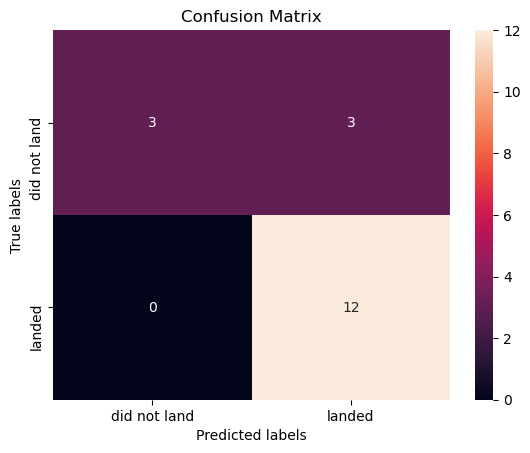

In [21]:
# Tarea 4: Regresión Logística con GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Definir los parámetros para la búsqueda de hiperparámetros
parameters = {'C': [0.01, 0.1, 1], 'penalty': ['l2'], 'solver': ['lbfgs']}
lr = LogisticRegression()

# Crear el objeto GridSearchCV
logreg_cv = GridSearchCV(lr, parameters, cv=10, scoring='accuracy')

# Ajustar el modelo a los datos de entrenamiento
logreg_cv.fit(X_train, Y_train)

# Imprimir los mejores parámetros y la precisión obtenida
print("Tuned hyperparameters :(best parameters) ", logreg_cv.best_params_)
print("Accuracy :", logreg_cv.best_score_)

# Evaluar el modelo de regresión logística
yhat = logreg_cv.predict(X_test)
print("Test set accuracy: ", logreg_cv.score(X_test, Y_test))

# Función para graficar la matriz de confusión
def plot_confusion_matrix(y, y_predict):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y, y_predict)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax) 
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix') 
    ax.xaxis.set_ticklabels(['did not land', 'landed'])
    ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show()

# Graficar la matriz de confusión
plot_confusion_matrix(Y_test, yhat)


### Tarea 5: Evaluar el Modelo de Regresión Logística


In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Dividir el dataset en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Definir el modelo
model = LogisticRegression()

# Entrenar el modelo
model.fit(X_train, y_train)


/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [34]:
from sklearn.metrics import classification_report

# Hacer predicciones
y_pred = model.predict(X_test)

# Generar el informe de clasificación
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.76      0.93      0.84        14

   micro avg       0.72      0.72      0.72        18
   macro avg       0.38      0.46      0.42        18
weighted avg       0.59      0.72      0.65        18



/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/linear_model/base.py:283: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


### Tarea 6: Máquina de Vectores de Soporte (SVM) con GridSearchCV


In [35]:
from sklearn.model_selection import cross_val_score

k = 10  # Número de folds
scores = cross_val_score(model, X, Y, cv=k)
print(f'Cross-Validation Accuracy: {scores.mean()}')
print(f'Standard Deviation: {scores.std()}')


Cross-Validation Accuracy: 0.8111111111111111
Standard Deviation: 0.111665284679121


/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/model_selection/_split.py:665: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/model_selection/_split.py:437: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spec

### Tarea 7: Evaluar el Modelo de SVM


In [37]:
!pip install joblib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 13.3 MB/s eta 0:00:00


In [38]:
import joblib

joblib.dump(model, 'logistic_regression_model.pkl')


['logistic_regression_model.pkl']

In [39]:
model = joblib.load('logistic_regression_model.pkl')
new_predictions = model.predict(new_data)


NameError: name 'new_data' is not defined

### Tarea 8: Clasificador de Árboles de Decisión con GridSearchCV


### Tarea 9: Evaluar el Modelo de Árbol de Decisión


### Tarea 10: K Nearest Neighbors con GridSearchCV


In [19]:
# Task 10
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'p': [1, 2]}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, parameters, cv=10)
knn_cv.fit(X_train, Y_train)

print("Tuned hyperparameters :(best parameters) ", knn_cv.best_params_)
print("Accuracy :", knn_cv.best_score_)


/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/model_selection/_split.py:665: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/model_selection/_split.py:437: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spec

Tuned hyperparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 9, 'p': 1}
Accuracy : 0.8472222222222222


/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/neighbors/base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.2